<img src = "https://github.com/barcelonagse-datascience/academic_files/raw/master/bgsedsc_0.jpg">
$\newcommand{\bb}{\boldsymbol{\beta}}$
$\DeclareMathOperator{\Gau}{\mathcal{N}}$
$\newcommand{\bphi}{\boldsymbol \phi}$
$\newcommand{\bx}{\boldsymbol{x}}$
$\newcommand{\bu}{\boldsymbol{u}}$
$\newcommand{\by}{\boldsymbol{y}}$
$\newcommand{\whbb}{\widehat{\bb}}$
$\newcommand{\hf}{\hat{f}}$
$\newcommand{\tf}{\tilde{f}}$
$\newcommand{\ybar}{\overline{y}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\Var}{Var}$
$\newcommand{\Cov}{Cov}$
$\newcommand{\Cor}{Cor}$

## Customer Churn Analysis and Classification

With the rapid development of telecommunication industry, the service providers are inclined more towards expansion of the subscriber base. To meet the need of surviving in the competitive environment, the retention of existing customers has become a huge challenge. It is stated that the cost of acquiring a new customer is far more than that for retaining the existing one. Therefore, it is imperative for the telecom industries to use advanced analytics to understand consumer behavior and in-turn predict the association of the customers as whether or not they will leave the company.

You are given a dataset: each row represents a customer and each column contains attributes related to customer as described:

+ Churn (target): 1 if customer cancelled service, 0 if not
+ AccountWeeks: number of weeks customer has had active account
+ ContractRenewal: 1 if customer recently renewed contract, 0 if not
+ DataPlan: 1 if customer has data plan, 0 if not
+ DataUsage: gigabytes of monthly data usage
+ CustServCalls: number of calls into customer service
+ DayMins: average daytime minutes per month
+ DayCalls: average number of daytime calls
+ MonthlyCharge: average monthly bill
+ OverageFee: largest overage fee in last 12 months
+ RoamMins: average number of roaming minutes


You are asked to **develop an algorithm** to be able to assess which are the customers that have the highest probability to churn. Besides that you will be asked to answer the 3 following questions:

1. **What variables are contributing to customer churn?** 
2. **Who are the customers more likely to churn?**
3. **What actions can be taken to stop them from leaving?**


You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Create extra variables if needed/possible
3. *Build* your model and test it on the same input data
4. Assess expected accuracy using *cross-validation*
5. Tune the hyperparameters of your model
6. Repeat steps 4 and 5 until you find the best model possible
7. Answer the questions asked

## Main criteria for grading
+ Algorithm implemented
+ AUC score given
+ At least Random Forest and Xgboost are used
+ Data preparation and exploration
+ Hyperparameter optimization 
+ Cross-validation used
+ Code is combined with neat and understandable commentary, with some titles and comments 

#Importing libraries and loading the dataset

In [1]:
#importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#for scaling
from sklearn.preprocessing import StandardScaler

#for plotting
#correlations matrix
import seaborn as sns 

#MODEL
#train-test split
from sklearn.model_selection import train_test_split

#kfold creation
from sklearn.model_selection import KFold

#RandomizedSearch for hyperParameter tunning
from sklearn.model_selection import RandomizedSearchCV

#RandomForest
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,\
                            AdaBoostClassifier, AdaBoostRegressor

#XGBoost model
import xgboost as xgb

#metrics
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,\
                          plot_confusion_matrix, roc_curve, roc_auc_score


In [37]:
#loading dataset for google colab
from google.colab import drive
drive.mount('/content/drive')
path_marcelo = ""
path_ben = ""
path_javier = "/content/drive/MyDrive/BSE/Computational Machine learning/assignments/Tree_based_models_project/"

ModuleNotFoundError: No module named 'google.colab'

In [2]:
#for local
path_javier = ""
file_name = "churn_data.csv"

In [3]:
#loading train data
df =  pd.read_csv(path_javier + file_name, sep = ";", decimal = ".")
df_copy = df.copy()
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


In [4]:
df.head(4)

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.0,2,299.4,71,57.0,3.10,6.6


In [5]:
#proportion of churn = 1
print("proportion of people that cancelled the service: {:.2f}".format(df_copy["Churn"].sum()/len(df_copy.index)))

proportion of people that cancelled the service: 0.14


Fontconfig warning: ignoring UTF-8: not a valid region tag


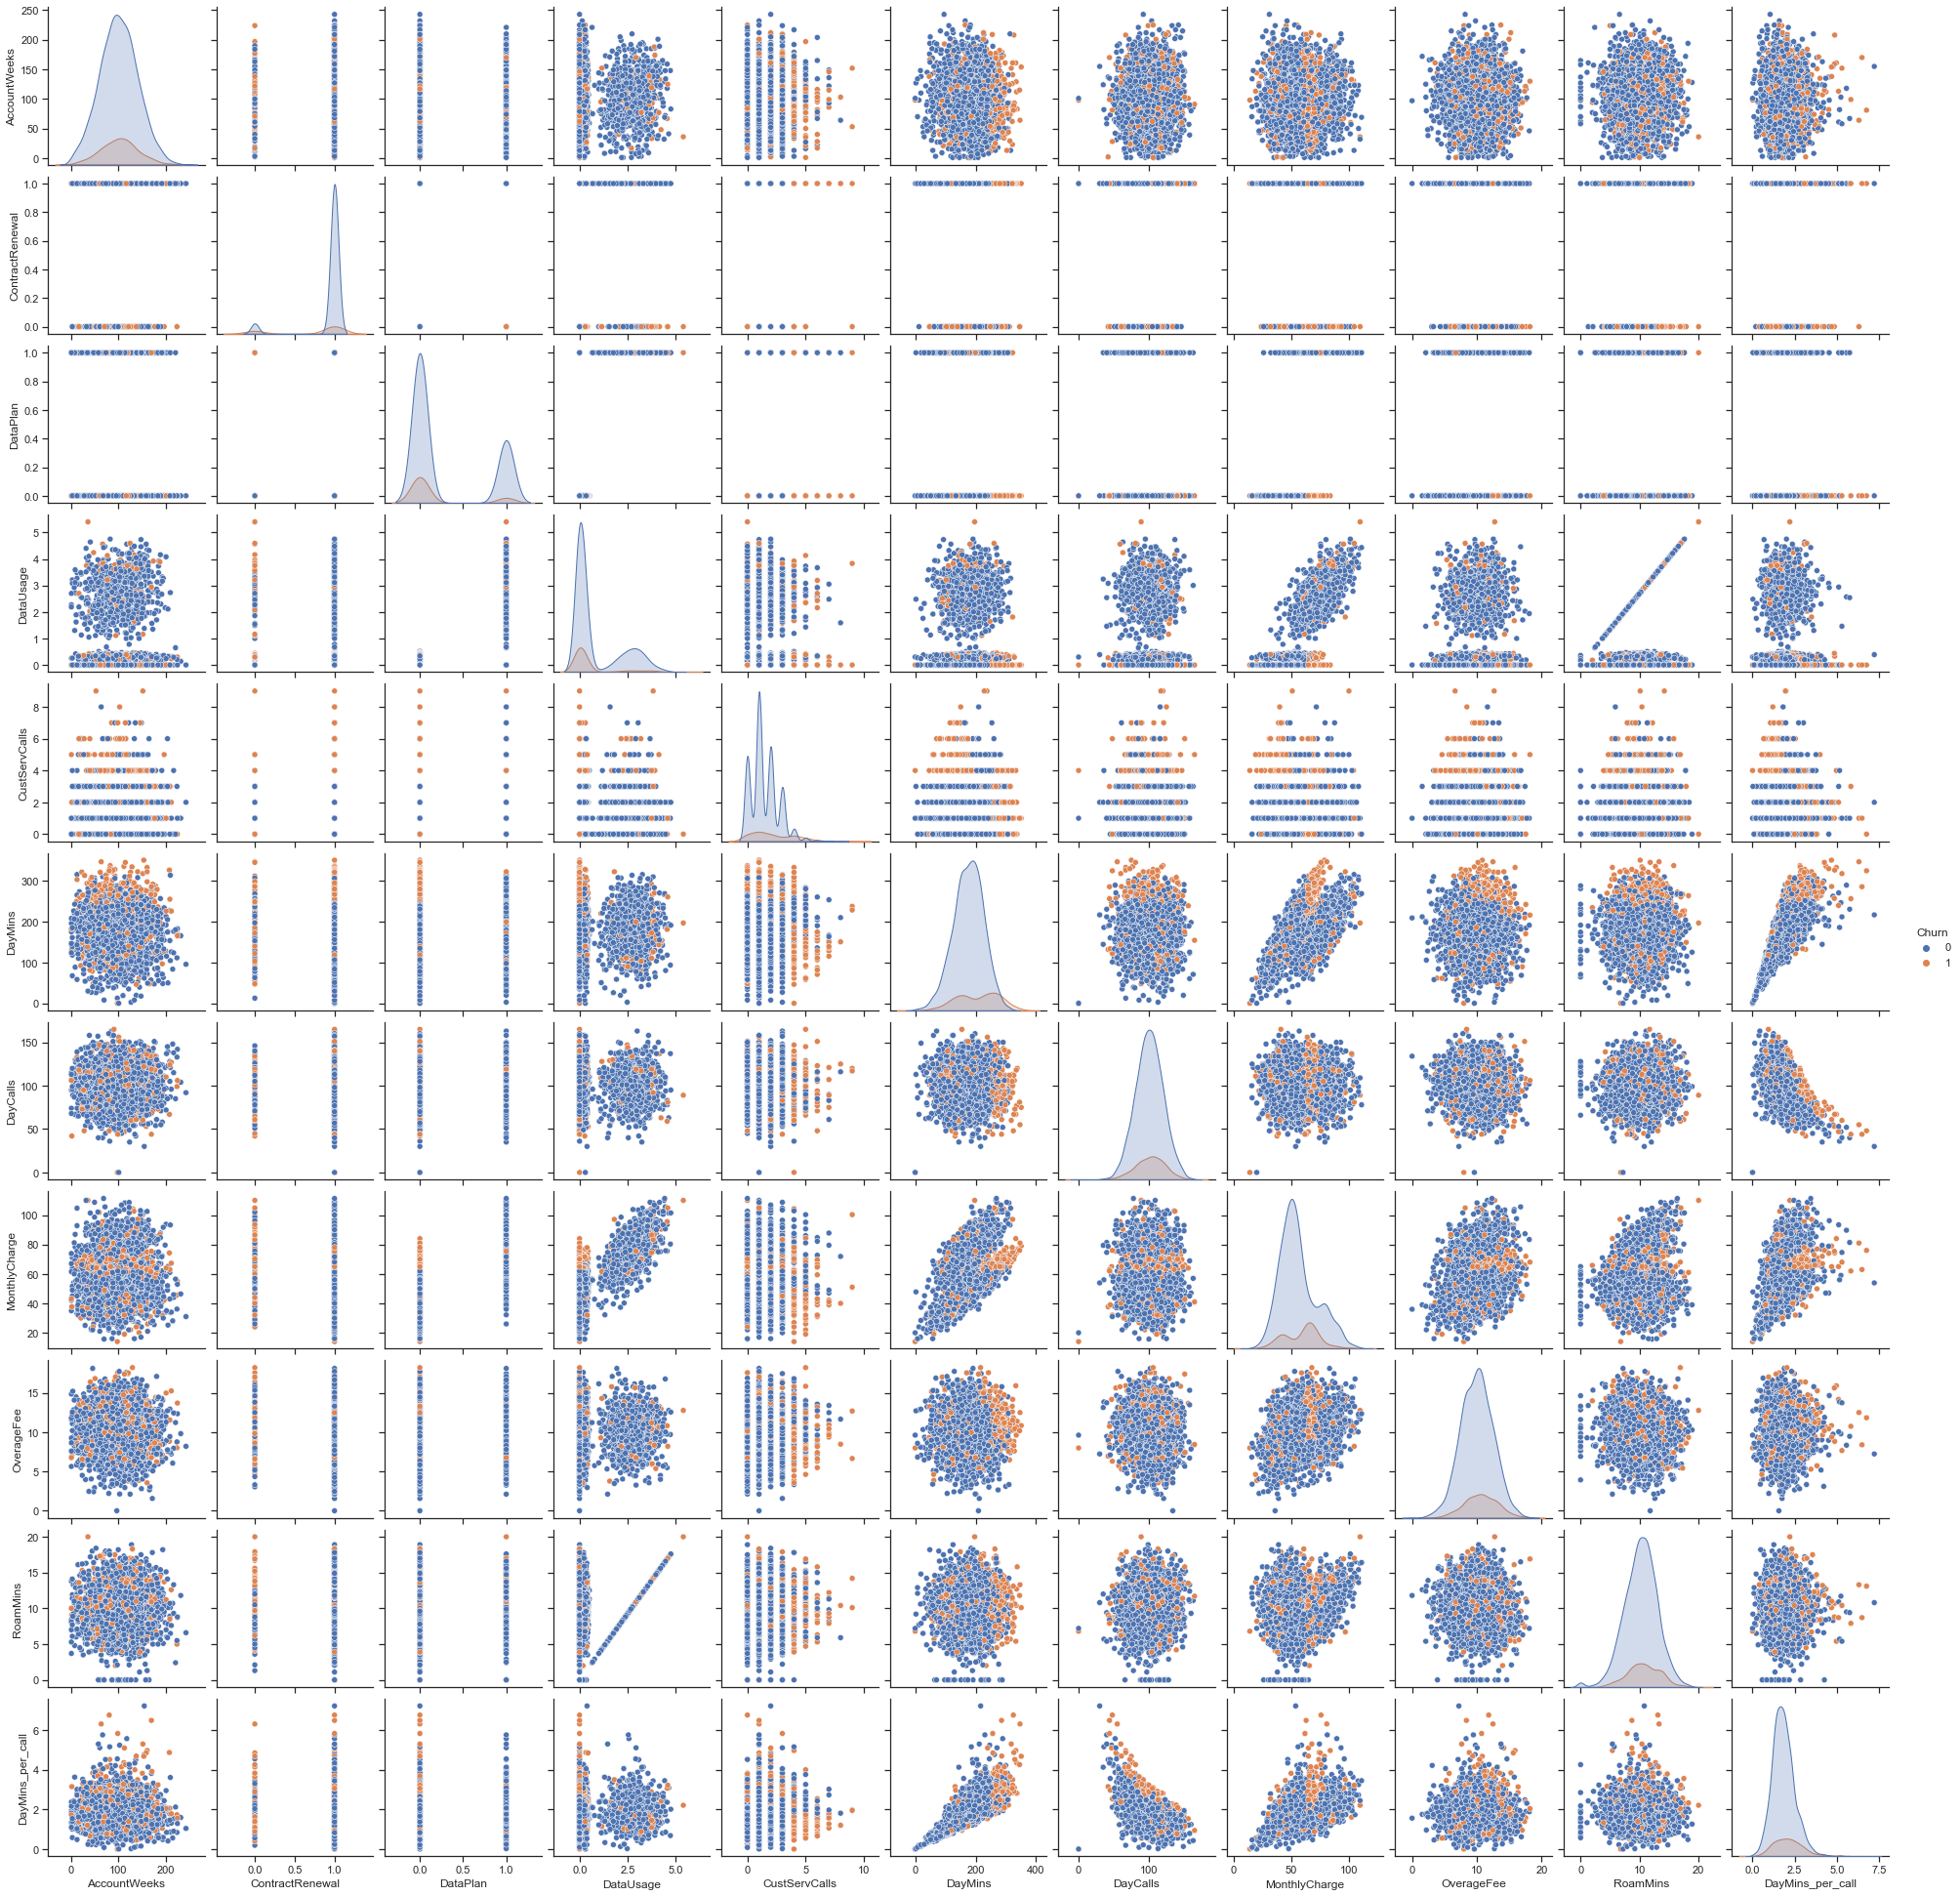

In [169]:
# Visualise the data

sns.set(style = "ticks")
sns.pairplot(df_copy, hue="Churn")

# Defining Functions and important vars

In [6]:
def check_categoricals_and_binaries(df, max_dif_cat_considered):
  """It gets the variables that are binary or categorical by checking first if the
  type of the variable is integer or string(we asume categorical values
  are integers and strings) and then if the number of possible values are 2 (binary) 
  or between 2 or a specified number of values (categorical). The inputs are
  the DataFrame and the int max_dif_cat_considered. The output is a list of names
  for the binary vars, and a dict for the categoricals with name : quantity of values.
  """
  categoricals = dict()
  binaries = list()
  for column in df.columns:
    dif_pos_values = len(df[column].unique())
    if dif_pos_values == 2:
      binaries.append(column)
    elif dif_pos_values > 2 and dif_pos_values < max_dif_cat_considered:
      categoricals[column] = dif_pos_values
  return binaries, categoricals


def check_outliers(df, vars_without_outliers):
  """It gets the df and a list of variables that dont have outliers (categorical
  and binary vars) and returns a dictionary with the total number of outliers
  and the index of them for each var that HAS outliers
  """
  outliers = dict()
  for column in df.columns:
    if column in vars_without_outliers:
      continue
    else:
      q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)

      IQR = q75 - q25
      lower,upper = q25 - IQR*1.5, q75 + IQR*1.5
      outliers_index = ((df[column] < lower) | (df[column] > upper))

      if len(outliers_index == True) == 0:
        continue
      else:
        output = {
            "indexes" : outliers_index,
            "quantity" : outliers_index.sum(axis = 0)
        }
        outliers[column] = output
  return outliers

def outliers_printer(df, vars_list):
  i=1
  plt.figure(figsize = (20,10))
  for col in vars_list:
   
    plt.subplot(3,3,i)
    sns.boxplot(df[col])

    i=i+1

def careful_standardization(df, not_standardize_list):
  """ This function receives the DataFrame and a list of variables not to standardize
  (for example the target, binary variables, or dummy variables(categorical vars
  should have been dummified). Also can receive sub strings of dummified categorical vars.
  For example, neigborhoodcode when dummified turns into neigborhoodcode_1, neigborhoodcode_2...
  so by putting the string 'neigborhoodcode_' inside the list no dummy of 'neigborhoodcode_' will
  be standardized). The output is the same DataFrame with all the other columns standardized. 
  """
  standardize_vars_cols = []
  dummy_vars_and_y = []

  for column in df.columns:
    for element in not_standardize_list:
    
      if element in column:
        save = False
        break
      else:
        save = True

    if save:
      standardize_vars_cols.append(column)
    else:
      dummy_vars_and_y.append(column)

  # scaler
  scaler = StandardScaler().fit(df[standardize_vars_cols])
  scaled_features = scaler.transform(df[standardize_vars_cols])
  df_scaled = pd.DataFrame(scaled_features, index = df.index, columns = df[standardize_vars_cols].columns)
  df_scaled[dummy_vars_and_y] = df[dummy_vars_and_y]

  return df_scaled


def CV_model(X , y, kf, model, metric, the_greater_the_better = True):
  """This function gets X and y sets, the KFold object to split the data, the model
  to evaluate, the metric to evaluate the model and an argument to set if the metric has to 
  be big or small (r2 the bigger the better, mse the smaller the better)"""
  metrics_list = []
  
  if the_greater_the_better:
    best_metric = 0
  
  if not the_greater_the_better:
    best_metric = 1000
  
  for train_index, test_index in kf.split(X):

    X_train, X_test = np.matrix(X)[train_index], np.matrix(X)[test_index]
    y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    metric_val = metric(y_test, y_pred)
    metrics_list.append(metric_val)

    if the_greater_the_better:

      if metric_val > best_metric:
        
        final_model = model
        final_X_test = X_test
        final_y_pred = y_pred
        final_y_test = y_test
        best_metric = metric_val
    else:

      if metric_val < best_metric:
        
        final_model = model
        final_X_test = X_test
        final_y_pred = y_pred
        final_y_test = y_test
        best_metric = metric_val

  return final_model, final_X_test, final_y_test, final_y_pred, np.mean(metrics_list)

In [7]:
#defining global vars that will be used through the project
TARGET = "Churn"
SEED = 1  #this var is for random states so we dont change it by mistake from one step to anodet (for consistency)
          #and putting this name will help with readibility too
FEATURES = None

# Working the Data

In [8]:
#detecting binary and categorical vars
binaries, categoricals = check_categoricals_and_binaries(df_copy, 50)
print(binaries)
print(categoricals)

['Churn', 'ContractRenewal', 'DataPlan']
{'CustServCalls': 10}


In [9]:
#detecting vars with outliers
vars_without_outliers = binaries + list(categoricals.keys())
outliers = check_outliers(df_copy, vars_without_outliers)

print(outliers.keys())

dict_keys(['AccountWeeks', 'DataUsage', 'DayMins', 'DayCalls', 'MonthlyCharge', 'OverageFee', 'RoamMins'])


/Users/javier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/javier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/javier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warning

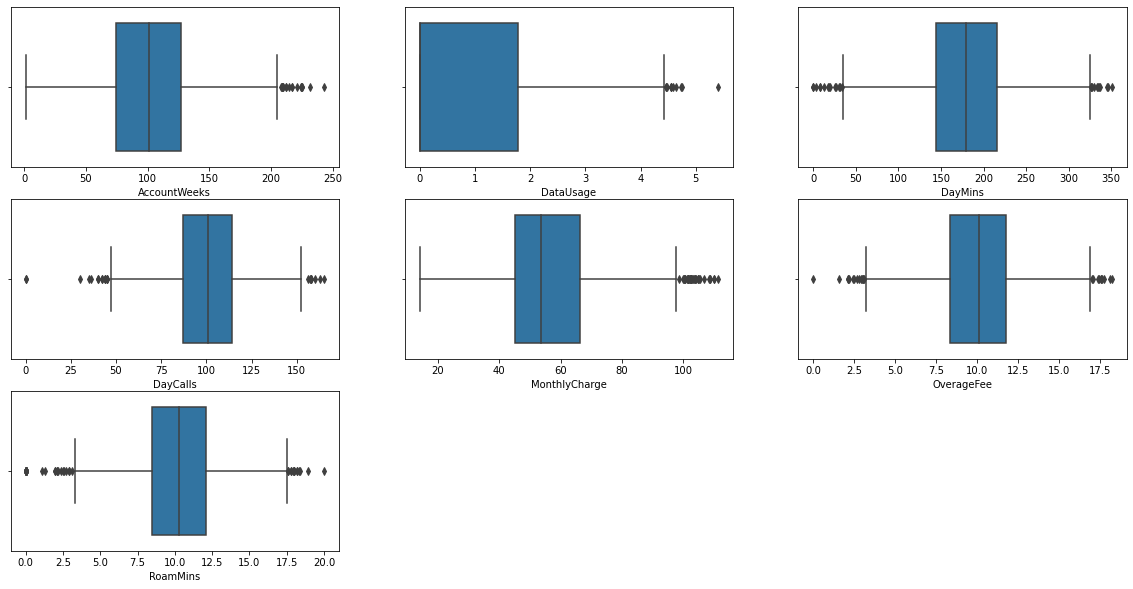

In [10]:
#visualizing outliers
outliers_printer(df_copy, outliers.keys())

In [11]:
#creating new vars (logs of non categorical nor binary vars for example) if needed
df_copy['DayMins_per_call'] = df_copy.apply(lambda row: round(row['DayMins']/(row['DayCalls']) 
                                                        if row['DayCalls'] != 0 else 0,2), axis = 1)
df_copy["OverageFee_X_DayMins"] = df_copy.apply(lambda row: row["OverageFee"]*row["DayMins"], axis = 1)
df_copy["DayMins_X_DayCalls"] = df_copy.apply(lambda row: row["DayCalls"]*row["DayMins"], axis = 1)
df_copy["AccountWeeks_X_DayMins"] = df_copy.apply(lambda row: row["AccountWeeks"]*row["DayMins"], axis = 1)


/var/folders/yw/h9ndkfbx6_lb6gwchxbgts2m0000gn/T/ipykernel_3995/2568435053.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df_corr, dtype=np.bool)


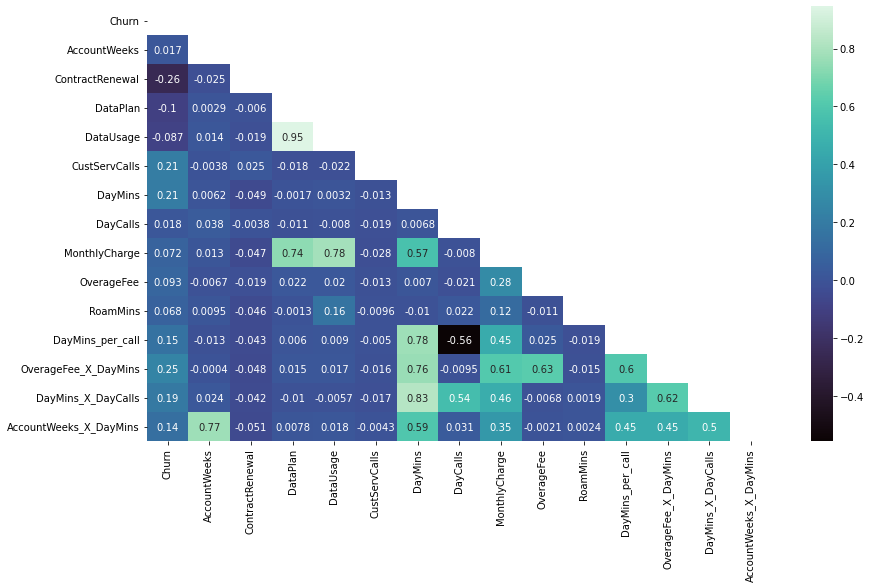

In [12]:
#visualazing correlation matrix
# Let's calculate the correlations
df_corr = df_copy.corr()

# Plot correlations
# Remove upper triangle
palette = sns.color_palette("mako", as_cmap=True)
fig, ax = plt.subplots(figsize=(14,8))
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(df_corr, mask = mask, annot = True, cmap = palette)

In [13]:
#separating into x and y and standardizing x. Not creating train and test sets yet
not_standardize_list = binaries
if TARGET not in binaries:
  not_standardize_list.append(TARGET)

df_scaled = careful_standardization(df_copy, not_standardize_list)
X = df_scaled.drop(columns=[TARGET])
y = df_scaled[TARGET]

df_scaled.head(4)

,AccountWeeks,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,DayMins_per_call,OverageFee_X_DayMins,DayMins_X_DayCalls,AccountWeeks_X_DayMins,Churn,ContractRenewal,DataPlan
0,0.676489,1.480204,-0.427932,1.566767,0.476643,1.990727,-0.071584,-0.085008,0.735059,1.112977,1.668992,1.689306,0,1,1
1,0.149065,2.266072,-0.427932,-0.333738,1.124503,1.564510,-0.107082,1.240482,-0.766212,-0.313196,0.272746,-0.095587,0,1,1
2,0.902529,-0.641642,-1.188218,1.168304,0.675985,-0.262133,-1.574346,0.703121,0.366565,-0.458339,1.456431,1.626347,0,1,0
3,-0.428590,-0.641642,0.332354,2.196596,-1.466936,0.042307,-2.741846,-1.303026,3.205333,-1.211096,0.480373,0.747265,0,0,0


In [14]:
FEATURES = list(X.columns)
FEATURES

['AccountWeeks',
 'DataUsage',
 'CustServCalls',
 'DayMins',
 'DayCalls',
 'MonthlyCharge',
 'OverageFee',
 'RoamMins',
 'DayMins_per_call',
 'OverageFee_X_DayMins',
 'DayMins_X_DayCalls',
 'AccountWeeks_X_DayMins',
 'ContractRenewal',
 'DataPlan']

# Model analysis

is this a regression or classification? not sure...

In [15]:
#building KFold object
kf = KFold(n_splits = 5, shuffle = True, random_state = SEED)

### Random Forest Classifier implementation

In [16]:
#creating Randomized search for hyperParameter tunning

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1000, stop = 1500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [1000, 1055, 1111, 1166, 1222, 1277, 1333, 1388, 1444, 1500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [17]:
#Algorithm implemented with cross-validation. #At least Random Forest and Xgboost are used.
#Cross-validation used
#AUC score given
#Hyperparameter optimization
#maybe we can define a set of functions that work together to loop through all the hyper parameters
#trying to find the optimum point. Maybe we can try regression and classification? Dont know
#which one will be the best one as we only have to give a 1/0 as a prediction. maybe regression together with
#optimizing for the best threshold using the f1 socre gives good results.
forest_class = RandomForestClassifier()

clf_randForestClass = RandomizedSearchCV(forest_class, random_grid, n_iter=10, scoring = "f1", n_jobs = 4, random_state=SEED, cv = 5)
clf_randForestClass.fit(X,y)
randForClass_params = clf_randForestClass.best_params_
forest_class.set_params(**randForClass_params)
print("Best parameters for Random Forest Classifier: {}".format(randForClass_params))                      

KeyboardInterrupt: 

In [18]:
best_randForClass, BestRandClass_X_test, BestRandClass_y_test, BestRandClass_y_pred, RandClass_CV_f1_score = CV_model(X , 
                                                                                        y, 
                                                                                        kf, 
                                                                                        forest_class, 
                                                                                        f1_score, 
                                                                                        the_greater_the_better = True)

accuracy_best_fold_RandForestClass = accuracy_score(BestRandClass_y_test, BestRandClass_y_pred)
precision_best_fold = precision_score(BestRandClass_y_test, BestRandClass_y_pred)
recall_best_fold = recall_score(BestRandClass_y_test, BestRandClass_y_pred)
f1_best_fold = f1_score(BestRandClass_y_test, BestRandClass_y_pred)
print("f1 score for Random Forest Classifier: {:.2f}".format(RandClass_CV_f1_score))
print("metrics for best fold. accuracy: %(a)s, precision: %(p)s, recall: %(r)s, f1 score: %(f)s"%{
                                                                                    'a':"{:.2f}".format(accuracy_best_fold_RandForestClass),
                                                                                    'p':"{:.2f}".format(precision_best_fold),
                                                                                    'r':"{:.2f}".format(recall_best_fold),
                                                                                    'f':"{:.2f}".format(f1_best_fold)
})


f1 score for Random Forest Classifier: 0.75
metrics for best fold. accuracy: 0.94, precision: 0.88, recall: 0.73, f1 score: 0.80


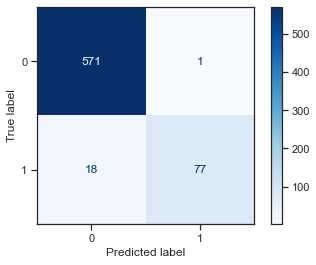

In [197]:
#confusion matrix
plot_confusion_matrix(best_randForClass, BestRandClass_X_test, BestRandClass_y_test, cmap=plt.cm.Blues, values_format = '.0f')

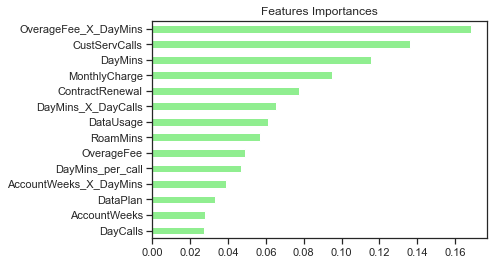

In [198]:
#results visualization. ROC curve of both, features importances, 
importances = pd.Series(data=best_randForClass.feature_importances_,
                        index= FEATURES)
 
# Sort importances
importances_sorted = importances.sort_values()
 
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

### XGBoost classifier implementation

In [19]:
#creating Randomized search for hyperParameter tunning

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 0, stop = 1000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]
max_depth.append(None)
gamma = [(x) for x in np.linspace(1, 9, num = 9)]
gamma.append(None)
reg_alpha = [(x) for x in np.linspace(40, 180, num = 15)]
reg_alpha.append(None)
reg_lambda = [(x) for x in np.linspace(0, 1, num = 11)]
reg_lambda.append(None)
colsample_bytree = [(x) for x in np.linspace(0.5, 1, num = 11)]
colsample_bytree.append(None)
min_child_weight = [(x) for x in np.linspace(0, 10, num = 11)]
min_child_weight.append(None)
learning_rate = [(x) for x in np.linspace(0, 1, num = 11)]
learning_rate.append(None)
# Create the random grid

random_grid = {'n_estimators': n_estimators,
                "gamma":gamma,
                "reg_alpha":reg_alpha,
               "reg_lambda":reg_lambda,
               "colsample_bytree":colsample_bytree,
               'max_depth': max_depth,
               "learning_rate": learning_rate
               }
print(random_grid)


{'n_estimators': [0, 111, 222, 333, 444, 555, 666, 777, 888, 1000], 'gamma': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, None], 'reg_alpha': [40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0, None], 'reg_lambda': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0, None], 'colsample_bytree': [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.8500000000000001, 0.9, 0.95, 1.0, None], 'max_depth': [10, 21, 32, 43, 54, 65, 76, 87, 98, 110, None], 'learning_rate': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0, None]}


In [20]:
XBGClass = xgb.XGBClassifier(objective='binary:logistic', nthread = 4)
print(XBGClass.get_params().keys())

dict_keys(['objective', 'use_label_encoder', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'gamma', 'gpu_id', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_threshold', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity', 'nthread'])


In [201]:
clf_XBGClass=RandomizedSearchCV(XBGClass,param_distributions=random_grid,n_iter=5,scoring='f1',n_jobs=-1,cv=5)
clf_XBGClass.fit(X,y)
clf_XBGClass_params = clf_XBGClass.best_params_
XBGClass.set_params(**clf_XBGClass_params)
print("Best parameters for XGBoost Classifier: {}".format(clf_XBGClass_params))  

Best parameters for XGBoost Classifier: {'reg_lambda': 0.7000000000000001, 'reg_alpha': 50.0, 'n_estimators': 444, 'max_depth': None, 'learning_rate': 0.1, 'gamma': 1.0, 'colsample_bytree': 0.95}


In [22]:
best_XBGClass, BestXBGClass_X_test, BestXBGClass_y_test, BestXBGClass_y_pred, XBGClass_CV_f1_score = CV_model(X , 
                                                                                        y, 
                                                                                        kf, 
                                                                                        XBGClass, 
                                                                                        f1_score, 
                                                                                        the_greater_the_better = True)

accuracy_best_fold_XGB = accuracy_score(BestXBGClass_y_test, BestXBGClass_y_pred)
precision_best_fold = precision_score(BestXBGClass_y_test, BestXBGClass_y_pred)
recall_best_fold = recall_score(BestXBGClass_y_test, BestXBGClass_y_pred)
f1_best_fold = f1_score(BestXBGClass_y_test, BestXBGClass_y_pred)
print("f1 score for Random Forest Classifier: {:.2f}".format(XBGClass_CV_f1_score))
print("metrics for best fold. accuracy: %(a)s, precision: %(p)s, recall: %(r)s, f1 score: %(f)s"%{
                                                                                    'a':"{:.2f}".format(accuracy_best_fold_XGB),
                                                                                    'p':"{:.2f}".format(precision_best_fold),
                                                                                    'r':"{:.2f}".format(recall_best_fold),
                                                                                    'f':"{:.2f}".format(f1_best_fold)
                                                                                })

f1 score for Random Forest Classifier: 0.74
metrics for best fold. accuracy: 0.94, precision: 0.85, recall: 0.70, f1 score: 0.77


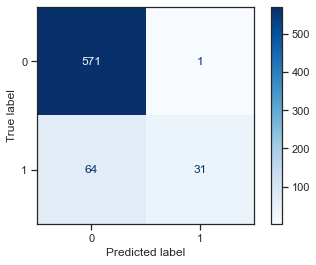

In [203]:
plot_confusion_matrix(best_XBGClass, BestXBGClass_X_test, BestXBGClass_y_test, cmap=plt.cm.Blues, values_format = '.0f')

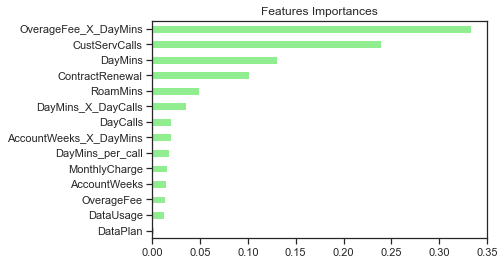

In [204]:
#results visualization. ROC curve of both, features importances, 
importances = pd.Series(data=best_XBGClass.feature_importances_,
                        index= FEATURES)
 
# Sort importances
importances_sorted = importances.sort_values()
 
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

### AdaBoost implementation

In [23]:
#creating Randomized search for hyperParameter tunning

n_estimators = [int(x) for x in np.linspace(start = 0, stop = 1000, num = 10)]
learning_rate = [(x) for x in np.linspace(0, 1, num = 11)]
learning_rate.append(None)
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               "learning_rate": learning_rate
               }
print(random_grid)



{'n_estimators': [0, 111, 222, 333, 444, 555, 666, 777, 888, 1000], 'learning_rate': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0, None]}


In [24]:
AdaClass = AdaBoostClassifier(base_estimator=None, algorithm='SAMME.R', random_state=SEED)
clf_AdaClass=RandomizedSearchCV(AdaClass,param_distributions=random_grid,n_iter=5,scoring='f1',n_jobs=4,cv=5)
clf_AdaClass.fit(X,y)
clf_AdaClass_params = clf_AdaClass.best_params_
AdaClass.set_params(**clf_AdaClass_params)

/Users/javier/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/javier/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/javier/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py", line 443, in fit
    return super().fit(X, y, sample_weight)
  File "/Users/javier/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py", line 102, in fit
    raise ValueError("learning_rate must be greater than zero")
ValueError: learning_rate must be greater than zero

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/javier/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_v

AdaBoostClassifier(learning_rate=0.4, n_estimators=666, random_state=1)

In [25]:
print("Best parameters for AdaBoost Classifier: {}".format(clf_AdaClass_params))

Best parameters for AdaBoost Classifier: {'n_estimators': 666, 'learning_rate': 0.4}


In [26]:
best_AdaClass, BestAdaClass_X_test, BestAdaClass_y_test, BestAdaClass_y_pred, AdaClass_CV_f1_score = CV_model(X , 
                                                                                        y, 
                                                                                        kf, 
                                                                                        AdaClass, 
                                                                                        f1_score, 
                                                                                        the_greater_the_better = True)

accuracy_best_fold_ADA = accuracy_score(BestAdaClass_y_test, BestAdaClass_y_pred)
precision_best_fold = precision_score(BestAdaClass_y_test, BestAdaClass_y_pred)
recall_best_fold = recall_score(BestAdaClass_y_test, BestAdaClass_y_pred)
f1_best_fold = f1_score(BestAdaClass_y_test, BestAdaClass_y_pred)
print("f1 score for Random Forest Classifier: {:.2f}".format(AdaClass_CV_f1_score))
print("metrics for best fold. accuracy: %(a)s, precision: %(p)s, recall: %(r)s, f1 score: %(f)s"%{
                                                                                    'a':"{:.2f}".format(accuracy_best_fold_ADA),
                                                                                    'p':"{:.2f}".format(precision_best_fold),
                                                                                    'r':"{:.2f}".format(recall_best_fold),
                                                                                    'f':"{:.2f}".format(f1_best_fold)
                                                                                })

f1 score for Random Forest Classifier: 0.54
metrics for best fold. accuracy: 0.90, precision: 0.71, recall: 0.54, f1 score: 0.61


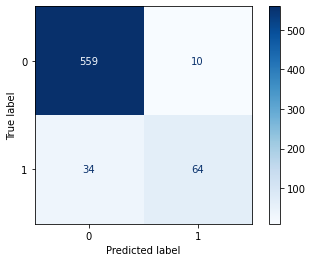

In [27]:
plot_confusion_matrix(best_AdaClass, BestAdaClass_X_test, BestAdaClass_y_test, cmap=plt.cm.Blues, values_format = '.0f')

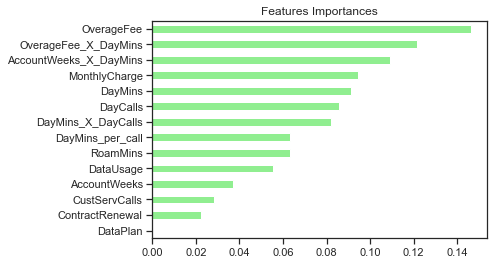

In [210]:
#results visualization. ROC curve of both, features importances, 
importances = pd.Series(data=best_AdaClass.feature_importances_,
                        index= FEATURES)
 
# Sort importances
importances_sorted = importances.sort_values()
 
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

### AUC plot

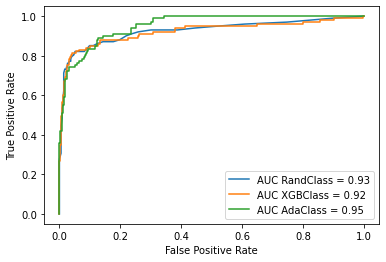

F1 score of RandClass: 0.75,
accuracy score of RandClass: 0.94,
F1 score of XGBClass: 0.74,
accuracy score of XGBClass: 0.94, 
F1 score of AdaClass: 0.54,
accuracy score of AdaClass: 0.90


"#FOR REGRESSIONS\n# Predict the test set labels\ny_pred = rf.predict(X_test)\nfpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)\n\n#create ROC curve\nplt.plot(fpr,tpr)\nplt.ylabel('True Positive Rate')\nplt.xlabel('False Positive Rate')\nplt.show()"

In [28]:
#FOR CLASSIFIERS
y_score_RandClass = best_randForClass.predict_proba(BestRandClass_X_test)[:,1]
fpr_RandClass, tpr_RandClass, _ = roc_curve(BestRandClass_y_test,  y_score_RandClass)
auc_RandClass = roc_auc_score(BestRandClass_y_test, y_score_RandClass)

y_score_XBGClass = best_XBGClass.predict_proba(BestXBGClass_X_test)[:,1]
fpr_XBGClass, tpr_XBGClass, _ = roc_curve(BestXBGClass_y_test,  y_score_XBGClass)
auc_XBGClass = roc_auc_score(BestXBGClass_y_test, y_score_XBGClass)

y_score_AdaClass = best_AdaClass.predict_proba(BestAdaClass_X_test)[:,1]
fpr_AdaClass, tpr_AdaClass, _ = roc_curve(BestAdaClass_y_test,  y_score_AdaClass)
auc_AdaClass = roc_auc_score(BestAdaClass_y_test, y_score_AdaClass)

#create ROC curve
plt.plot(fpr_RandClass,tpr_RandClass, label="AUC RandClass = {:.2f}".format(auc_RandClass))
plt.plot(fpr_XBGClass,tpr_XBGClass, label="AUC XGBClass = {:.2f}".format(auc_XBGClass))
plt.plot(fpr_AdaClass,tpr_AdaClass, label="AUC AdaClass = {:.2f}".format(auc_AdaClass))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

print(  "F1 score of RandClass: %(F1RC)s,\n\
accuracy score of RandClass: %(ACCRC)s,\n\
F1 score of XGBClass: %(F1XGB)s,\n\
accuracy score of XGBClass: %(ACCXGB)s, \n\
F1 score of AdaClass: %(F1ADA)s,\n\
accuracy score of AdaClass: %(ACCADA)s"%{  "F1RC": "{:.2f}".format(RandClass_CV_f1_score),
                                        "ACCRC": "{:.2f}".format(accuracy_best_fold_RandForestClass),
                                        "F1XGB": "{:.2f}".format(XBGClass_CV_f1_score),
                                        "ACCXGB": "{:.2f}".format(accuracy_best_fold_XGB),
                                        "F1ADA": "{:.2f}".format(AdaClass_CV_f1_score),
                                        "ACCADA": "{:.2f}".format(accuracy_best_fold_ADA)
                                        })

"""#FOR REGRESSIONS
# Predict the test set labels
y_pred = rf.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()"""

The best model is the Random Forest classificator, as it is the model with better AUC and also with better F1 score and accuracy. 